<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202402/blob/main/Lecture03/Lecture03_bootstrap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# The Bootstrap


## Introduction


The bootstrap is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method. 

As a simple example, the bootstrap can be used to estimate the standard errors of the coefficients from a linear regression fit. 

In the specific case of linear regression, this is not particularly useful, since standard statistical software outputs such standard errors automatically.

However, the power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.

Let's illustrate this with an example. The objective is to estimate gasoline demand's elasticity and quantify its associated uncertainty.


Suppose we have the following data to estimate the elasticity where all the variables are in logs:

In [ ]:
#install.packages("pacman") for #google colab

In [1]:
gas<-read.csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/gas.csv",header=T)
head(gas)


,consumption,price,income
,<dbl>,<dbl>,<dbl>
1,5.090526,-1.602419,2.342972
2,5.092324,-1.572913,2.317068
3,5.093950,-1.547504,2.340076
4,5.067488,-1.505120,2.323478
5,5.049762,-1.456725,2.335196
6,5.049566,-1.438641,2.364967



Before estimating different models, let's recall that the elasticity of demand, usually denoted by $\eta_{qp}$, is the percentage change in the quantity demanded divided by the percentage change in the price.  It gives the percentage change in quantity demanded when there is a one percent increase in price, holding everything else constant:

\begin{align}
\eta_{qp} &=\frac{\frac{\partial Q}{Q}}{\frac{\partial P}{P}} \\
          &=\frac{\partial Q}{\partial P}\frac{P}{Q}
\end{align}

## Case 1



To begin with, let's suppose that the demand model takes the form:

$$
\ln{Quantity}_{t}= \alpha + \beta_1 \ln{Price}_{t} +\beta_2 \ln{Income}_{t} +u_{t}
$$

given this specification, we have that the elasticity of demand is the coefficient associated with `lnPrice`



$$
\eta_{qp} =\beta_1
$$

Let's estimate this

In [2]:
require("pacman")
p_load("tidyverse","stargazer")

mod1<- lm(consumption~price+income,gas)
stargazer(mod1,type="text", omit.stat=c("ser","f","adj.rsq"))


Loading required package: pacman




                 Dependent variable:    
             ---------------------------
                     consumption        
----------------------------------------
price                 -0.838***         
                       (0.025)          
                                        
income                2.117***          
                       (0.048)          
                                        
Constant              -1.056***         
                       (0.158)          
                                        
----------------------------------------
Observations             246            
R2                      0.917           
Note:        *p<0.1; **p<0.05; ***p<0.01


Thus the elasticity of demand, given the above specification, is -0.838, and the standard error of that elasticity of demand is 0.025. 


In [3]:
str(mod1)

List of 12
 $ coefficients : Named num [1:3] -1.056 -0.838 2.117
  ..- attr(*, "names")= chr [1:3] "(Intercept)" "price" "income"
 $ residuals    : Named num [1:246] -0.1566 -0.0752 -0.101 -0.0568 -0.0587 ...
  ..- attr(*, "names")= chr [1:246] "1" "2" "3" "4" ...
 $ effects      : Named num [1:246] -90.1731 2.6074 4.0818 -0.0353 -0.037 ...
  ..- attr(*, "names")= chr [1:246] "(Intercept)" "price" "income" "" ...
 $ rank         : int 3
 $ fitted.values: Named num [1:246] 5.25 5.17 5.19 5.12 5.11 ...
  ..- attr(*, "names")= chr [1:246] "1" "2" "3" "4" ...
 $ assign       : int [1:3] 0 1 2
 $ qr           :List of 5
  ..$ qr   : num [1:246, 1:3] -15.6844 0.0638 0.0638 0.0638 0.0638 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:246] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:3] "(Intercept)" "price" "income"
  .. ..- attr(*, "assign")= int [1:3] 0 1 2
  ..$ qraux: num [1:3] 1.06 1.09 1.07
  ..$ pivot: int [1:3] 1 2 3
  ..$ tol  : num 1e-07
  ..$ rank : int 3
  ..- attr(*,

In [5]:
mod1$coefficients

(Intercept)       price      income 
 -1.0561479  -0.8383634   2.1168926

In [6]:
round(mod1$coefficients[2],3)

price 
-0.838



We can also find the standard error using *bootstrap*. In general terms, if $\theta$ is the magnitude of interest (in our case, is $\eta_{qp} =\beta_1$) we need to perform the following steps:
    
  1. Take a sample of size $n$ with replacement ( *bootstrap sample*)
  2. Compute $\hat{\theta}_j$ $j=1,\dots,B$, here it would be  $\eta_{qp} =\beta_1$ 
  3. Repeat $B$ times
  4. Calculate the standard error


Let's implement the bootstrap in two ways: "by hand", and using the package `boot`.

The first step is to tell `R`  a seed so results are reproducible and set the number of bootstrap samples $B$:

In [9]:
set.seed(123)

B<-1000 # Number of Repetions()

eta_mod1<-rep(NA,B)#this is an empty vector where we are going to save our elasticity estimates
length(eta_mod1)

[1] 1000

Next, we have to create a loop that takes a sample of size $n$ with replacement, estimates the coefficient of interest, and saves it to the above empty vector.

In [10]:
for(i in 1:B){
        
      db_sample<- sample_frac(gas,size=1,replace=TRUE) #takes a sample with replacement of the same size of the original sample (1 or 100%)
        
      f<-lm(consumption~price+income,db_sample)# estimates the models
      
      coefs<-f$coefficients[2] # gets the coefficient of interest that coincides with the elasticity of demand
      
      eta_mod1[i]<-coefs #saves it in the above vector
    }

We can check that we have B=1000 estimates of the elasticity of demand

In [11]:
length(eta_mod1)

[1] 1000

We can plot the sampling distribution of the estimated elasticity of demand

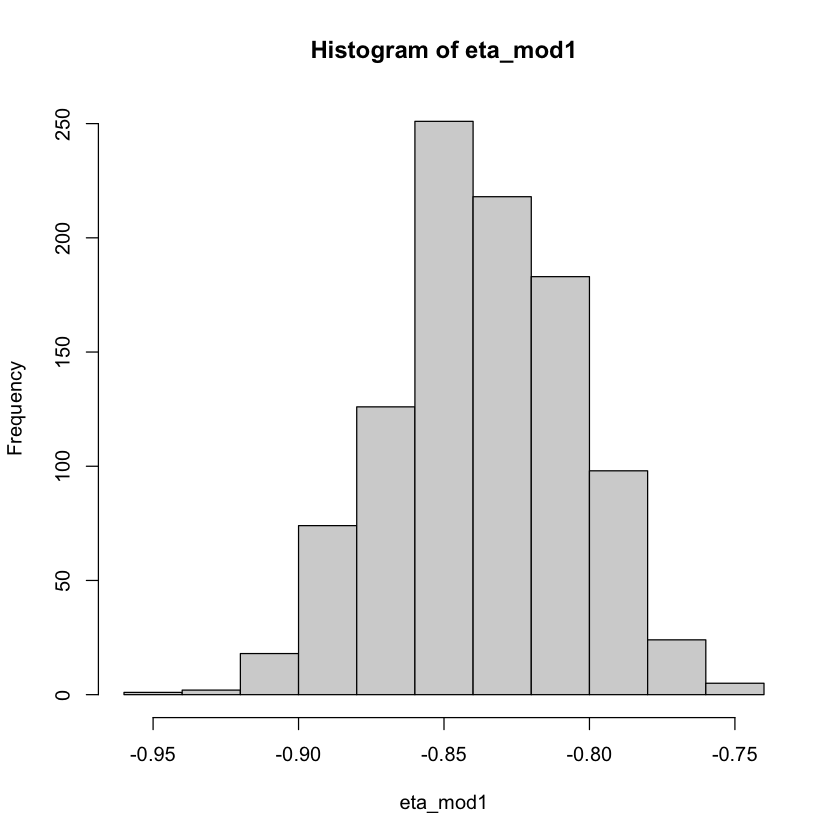

In [12]:
plot(hist(eta_mod1))

Obtain the mean

In [13]:
mean(eta_mod1)

[1] -0.8370501

and finally, obtain the standard error

In [14]:
sqrt(var(eta_mod1))

[1] 0.03146234

We could also estimate any quantity, for example the 2.5%. and 97.5% percentiles

In [15]:
quantile(eta_mod1,c(0.025,0.975))

2.5%      97.5% 
-0.8988958 -0.7783816

### Bootstrap with the boot package

`R` as it is a heavily used software by statisticians and econometricians, it already includes a package that simplifies and speeds up obtaining standard errors using bootstrap

In [16]:
p_load("boot")

This package contains the function `boot` that takes 3 arguments: 

`boot(data, statistic, R)`

the data set, a function which, when applied to data, returns a vector containing the statistic(s) of interest, and the number of desired bootstrap replicates. The first and the third arguments are straightforward. The second, however, needs more explanation



The `boot` function requires a second argument which is a function. This function needs at least two arguments, a data set and an index, which tells `R` which points it should use for its estimation. The indexing strategy speeds up the computation of the bootstrap samples.

With that, we can tell the function what to return. In this case, we care about the second coefficient of the linear regression:  `consumption~price+income` 

In [19]:
eta_fn<-function(data,index){
  
  coef(lm(consumption~price+income, data = data, subset = index))[2] #returns the second coefficient of the linear regression
}

Let's check that it works. We give the function our `gas` data and tell it to use all the observations from 1 to the last row:


In [20]:
eta_fn(gas,1:nrow(gas))

price 
-0.8383634

We get the same coefficient shown in our results table. So we know that the function is working. With that, we can estimate the standard error using the `boot` function:

In [21]:
set.seed(123)
#call the boot function
boot(gas, eta_fn, R = 1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = gas, statistic = eta_fn, R = 1000)


Bootstrap Statistics :
      original      bias    std. error
t1* -0.8383634 0.001689902  0.03281214

We get similar results from our estimates by hand. The small differences are given by the sampling strategy implemented by `boot` which is more efficient than the one implemented by us.

Note also that the estimates obtained by bootstrapping differ from those returned by `lm.` **Why?**

## Case 2


The previous case was not particularly useful since the specification resulted in the elasticity of demand coinciding with a coefficient, and `R` outputs standard errors automatically. However, the power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise challenging to obtain and is not automatically output by statistical software.

For example, let's suppose that the model is now the following

$$\ln{Quantity}_{t}= \beta_0 + \beta_1 \ln{Price}_{t}  + \beta_2 \ln{Price}^2_{t} +\beta_3 \ln{Income}_{t}+ \beta_4 \ln{Price}_{t}\times \ln{Income}_{t} +u_{t}$$

given this specification, the elasticity of demand implied by this model is:


$$
\eta_{qp} =\beta_1 + 2*\beta_2 \ln{Price} + \beta_4  \ln{Income}_{t}
$$
Then the elasticity is the combination of 3 coefficients. Thus the uncertainty associated with this quantity should account for the uncertainty coming from all of them.


Let's then estimate the model and calculate the elasticity of demand. First, we need  to generate the quadratic and interaction terms: 

In [22]:
gas<- gas %>% mutate(price2=price^2, 
                     price_income=price*income )

In [23]:
head(gas)

,consumption,price,income,price2,price_income
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.090526,-1.602419,2.342972,2.567746,-3.754423
2,5.092324,-1.572913,2.317068,2.474054,-3.644545
3,5.093950,-1.547504,2.340076,2.394769,-3.621277
4,5.067488,-1.505120,2.323478,2.265387,-3.497114
5,5.049762,-1.456725,2.335196,2.122048,-3.401739
6,5.049566,-1.438641,2.364967,2.069689,-3.402340


then regress: 

In [24]:
mod2<-lm(consumption~price+price2+income+price_income,gas)
stargazer(mod1,mod2,type="text")


                                     Dependent variable:                 
                    -----------------------------------------------------
                                         consumption                     
                               (1)                        (2)            
-------------------------------------------------------------------------
price                       -0.838***                  -1.783***         
                             (0.025)                    (0.141)          
                                                                         
price2                                                 -0.299***         
                                                        (0.021)          
                                                                         
income                       2.117***                   1.973***         
                             (0.048)                    (0.041)          
                                     

 To do that you will need to: 
 
i) Obtain the coefficients of regression: 

In [25]:
coefs<-mod2$coef
coefs 

(Intercept)        price       price2       income price_income 
  -0.5081995   -1.7825417   -0.2986801    1.9734354    0.2788964

ii) Extract the coefficients to scalars: 

In [26]:
    b0<-coefs[1] 
    b1<-coefs[2]
    b2<-coefs[3] 
    b3<-coefs[4]
    b4<-coefs[5] 

iii) We need a value at which to estimate the elasticity since it depends on price and income ($\eta_{qp} =\beta_1 + 2\beta_2 \ln{Price} + \beta_4  \ln{Income}_{t}$). Here we are going to choose the sample mean, but you can do it at any point:

In [27]:
price_bar<-mean(gas$price)
income_bar<-mean(gas$income)


elastpt<-b1+2*b2*price_bar+b4*income_bar
    
elastpt

price 
-0.671777

Note that the elasticity of demand implied by the second model is smaller than the previous one. Next, we need to calculate the standard errors to characterize this demand's uncertainty. 

Let's turn to the boot package and construct the function that will return the elasticity of interest.


In [28]:

eta_mod2_fn<-function(data,index,
                      price_bar=mean(gas$price),
                      income_bar=mean(gas$income)){
      
      f<-lm(consumption~price+price2+income+price_income,data, subset = index)
      
      coefs<-f$coefficients
        
        b1<-coefs[2]
        b2<-coefs[3] 
        b4<-coefs[5] 
    
      elastpt<-b1+2*b2*price_bar+b4*income_bar
    
    
      return(elastpt)
    }


  

The function is similar to the first case. Still, we have added two arguments; the points where we want the elasticity to be evaluated, in this case, the sample means. Let's check that it works

In [29]:
eta_mod2_fn(gas,1:nrow(gas))

price 
-0.671777

We get the same result as above. Let's evaluate it at different points of the distribution of price and income:


In [30]:
eta_mod2_fn(gas,1:nrow(gas),price_bar=-1,income_bar=2)  

price 
-0.6273886

With our function working, we can run `boot` and obtain the standard error for our elasticity:

In [31]:
#función boot requires, data (gas), 
#requires a statistic
# requires number of replications
results <- boot(data=gas, eta_mod2_fn,R=1000)
results


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = gas, statistic = eta_mod2_fn, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* -0.671777 0.0001012075   0.0151973